# Evaluate Multi-Fidelity Learning
See whether our strategy of delta learning leads to acceptable model performance.
A model which predicts multiple levels concurrently does not need to be better than a model which only predict a single level to be useful,
but we don't want it to be substantially worse.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

Configuration

In [2]:
target = ('oxidation_potential', 'cp2k_b3lyp_tzvpd-acn-adiabatic')

## Load Model Summaries
Load the data from the first notebook.

In [3]:
summary = pd.read_csv('model-summary.csv')
summary.query(f'target_property=="{target[0]}" and target_method=="{target[1]}"', inplace=True)
summary.sort_values('level_count', inplace=True)
print(f'Found {len(summary)} relevant models')

Found 6 relevant models


## Does the model improve with more levels?
Most of the predictions of our model will be made without any low-fidelity data to enhance them, let's make sure the multi-fidelity model still works well for such models.

Get the best combination of fidelities for each number of levels

In [4]:
best_level_0 = summary.sort_values(['level_count', 'level_0_mean_absolute_error'], ascending=True).drop_duplicates('level_count', keep='first')
print(f'Reduced to {len(best_level_0)} choices')

Reduced to 4 choices


In [5]:
best_level_0[['level_count', 'lower_levels', 'level_0_mean_absolute_error']]

,level_count,lower_levels,level_0_mean_absolute_error
1,0,[],0.173865
5,1,['xtb-adiabatic'],0.196051
6,2,"['xtb-adiabatic', 'cp2k_b3lyp_svp-acn-adiabatic']",0.207643
0,3,"['xtb-adiabatic', 'cp2k_b3lyp_svp-acn-vertical...",0.169955


Text(0.5, 0, 'Level Count')

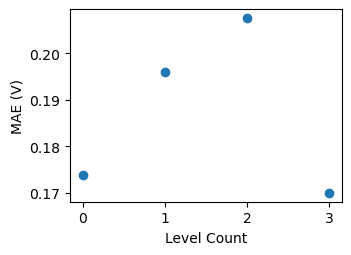

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(best_level_0['level_count'], best_level_0['level_0_mean_absolute_error'], 'o')

ax.set_ylabel('MAE (V)')
ax.set_xlabel('Level Count')

The model performance is slightly better with three levels of fidelity, but our test set size is small enough that I wouldn't make too much out of this or the decreased performance with levels 1-2.

## Does the performance increase with more data?
A core idea behind of our multi-fidelity strategy is that we can make better inferences of a molecule's properties as we gather more data.

In [7]:
best_multilevel = best_level_0.iloc[-1]

Plot the MAE as a function of level

Text(0, 0.5, 'MAE (V)')

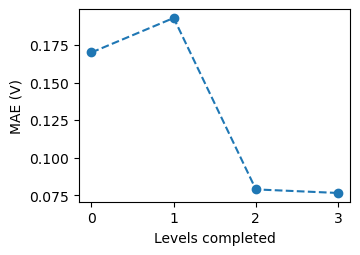

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

maes = [best_multilevel[f'level_{i}_mean_absolute_error'] for i in range(best_multilevel['level_count'] + 1)]
ax.plot(maes, '--o')

ax.set_xlabel('Levels completed')
ax.set_ylabel('MAE (V)')

The error goes up from "nothing" to "xtb done," which is a little surprising.